In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, \
f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [4]:
mushroom_data=pd.read_csv('mushrooms-full-dataset.csv',dtype=str)
mushroom_data.head()

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [5]:
mushroom_data['poisonous'].value_counts()

e    4208
p    3916
Name: poisonous, dtype: int64

In [6]:
mushroom_data.isnull().sum()

poisonous                   0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

# Preprocessing

In [7]:
target = mushroom_data['poisonous']
inputs = mushroom_data.drop(['poisonous'], axis=1)

In [8]:
x_train, x_test, y_train, y_test= train_test_split(inputs, 
                                                   target, 
                                                   test_size=0.2,
                                                   stratify=target)

In [9]:
y_train.value_counts()

e    3366
p    3133
Name: poisonous, dtype: int64

In [10]:
y_test.value_counts()

e    842
p    783
Name: poisonous, dtype: int64

In [13]:
enc_i=OrdinalEncoder()
enc_t=LabelEncoder()

In [14]:
x_train_transf=enc_i.fit_transform(x_train)
x_test_transf=enc_i.fit_transform(x_test)

y_train_transf=enc_t.fit_transform(y_train)
y_test_transf=enc_t.fit_transform(y_test)

In [17]:
y_train_transf

array([0, 1, 1, ..., 1, 1, 0])

In [18]:
x_train_transf

array([[5., 0., 4., ..., 2., 3., 1.],
       [2., 0., 9., ..., 1., 4., 1.],
       [3., 2., 2., ..., 7., 4., 4.],
       ...,
       [3., 2., 2., ..., 7., 4., 2.],
       [5., 3., 2., ..., 7., 4., 0.],
       [0., 2., 4., ..., 8., 4., 2.]])

In [19]:
scaling=MinMaxScaler(feature_range = (-1,1)).fit(x_train_transf)
x_train_rescaled = scaling.transform(x_train_transf)

# Classification

In [20]:
C = 1.0
svc= svm.SVC(kernel='linear', C=C).fit(x_train_rescaled,y_train_transf)

In [21]:
y_pred_test = svc.predict(scaling.transform(x_test_transf))

# Model Evaluation

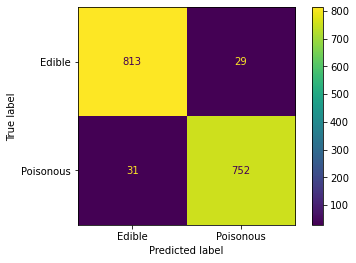

In [25]:
#fig, ax=plt.subplots(figsize=(0,5))

cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test_transf,y_pred_test),
    display_labels=['Edible', 'Poisonous'],
)

cmp.plot()

In [26]:
print(classification_report(y_test_transf,y_pred_test, target_names=['Edible', 'Poisonous']))

              precision    recall  f1-score   support

      Edible       0.96      0.97      0.96       842
   Poisonous       0.96      0.96      0.96       783

    accuracy                           0.96      1625
   macro avg       0.96      0.96      0.96      1625
weighted avg       0.96      0.96      0.96      1625



# Hyperparameter Tuning with GridSearchCV

## Choose the best kernel and optimal C parameter based on Cross Validation of the training data

In [27]:
tuned_parameters=[
    {'kernel':['linear'], 'C':[1,10]},
    {'kernel':['poly'], 'C':[1,10]},
    {'kernel':['rbf'], 'gamma':[1e-3,1e-4], 'C':[1,10]},

]

In [28]:
scores = ['precision','recall']

In [31]:
for score in scores:
    print('# Tuning hyper-parameters for %s' % score)
    print()
    
    clf = GridSearchCV(svm.SVC(), tuned_parameters, scoring='%s_macro' % score)
    clf.fit(x_train_rescaled, y_train_transf)
    
    print('Best parameters set found on development set:')
    print()
    print(clf.best_params_)
    print()
    print('Grid scores on development set: ')
    print()
    means = clf.cv_results_['mean_test_score'] #avergae accuracy of each model
    stds = clf.cv_results_['std_test_score'] #standard deviation of each model
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print('%0.3f (+/-%0.03f) for %r' %(mean,std*2,params))
    print()
    
    print('Detailed classification report:')
    print()
    print('The model is trained on the full development set.')
    print('The scores are computed on the full evaluation set.')
    print()
    y_true,y_pred=y_test_transf, clf.predict(scaling.transform(x_test_transf))
    print(classification_report(y_true,y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'kernel': 'poly'}

Grid scores on development set: 

0.950 (+/-0.016) for {'C': 1, 'kernel': 'linear'}
0.961 (+/-0.008) for {'C': 10, 'kernel': 'linear'}
1.000 (+/-0.000) for {'C': 1, 'kernel': 'poly'}
1.000 (+/-0.000) for {'C': 10, 'kernel': 'poly'}
0.929 (+/-0.031) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.896 (+/-0.032) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.949 (+/-0.021) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.929 (+/-0.031) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.